# 草，预处理出问题了

标准栅格发现有空洞，于是在修补的过程中，一边跑代码，一边在写考虑后面建模的代码

In [6]:
import os
import gc
import numpy as np
import xarray as xr
import rioxarray

# —— 1. 路径设置 ——
tif_path = r'D:\Photovoltaic_data\Global_rast_gdpTot_1990_2020_30arcsec.tif'
nc_path  = r'D:\xarray\aligned2\firstmask.nc'

os.makedirs(os.path.dirname(nc_path), exist_ok=True)

# —— 2. 读取 GeoTIFF 为 DataArray ——
da = rioxarray.open_rasterio(tif_path, masked=True)
# 取第一个波段而不是squeeze
if 'band' in da.dims:
    da = da.isel(band=0)

# 重命名坐标一致为 lat/lon
if 'x' in da.dims and 'y' in da.dims:
    da = da.rename({'x': 'lon', 'y': 'lat'})


# —— 3. 构建陆域掩膜 ——
land_mask = da.notnull().astype(bool)
land_mask.name = 'land_mask'
land_mask.attrs['description'] = 'True where population density is valid'

# —— 4. 打包为 Dataset ——
ds = xr.Dataset(
    {
        'land_mask':   land_mask
    },
    coords={'lat': da['lat'], 'lon': da['lon']},
    attrs={'title': 'Population Density with simple land mask'}
)

# —— 5. 优化编码并保存 ——
encoding = {
    'land_mask': {
        'dtype': 'bool', 'zlib': True, 'complevel': 5
    }
}
ds.to_netcdf(nc_path, encoding=encoding)

# —— 6. 清理内存 ——
del ds, da, land_mask
gc.collect()

print(f"✅ 已保存简单 NetCDF：{nc_path}")


✅ 已保存简单 NetCDF：D:\xarray\aligned2\firstmask.nc


In [7]:
import xarray as xr
from pathlib import Path
import numpy as np

MASTER = r"D:\xarray\aligned2\firstmask.nc"
FINAL  = r"D:\xarray\final_mask_1km_new.nc"
OUT    = r"D:\xarray\aligned2\master_final.nc"

# 1) 读取
master = xr.open_dataset(MASTER).land_mask          # (lat, lon)
final  = xr.open_dataset(FINAL).final_mask          # (lat, lon 或 y,x)

# 2) 若 final 用 y/x → 改成 lat/lon（不依赖 rioxarray）
if {"x","y"}.issubset(final.dims):
    final = final.rename({"x":"lon", "y":"lat"})

# 3) 对齐：最近邻插值到 final 网格
# 将布尔类型转换为数值类型，因为interp只能处理数值类型数组
master_numeric = master.astype("uint8")  # 将布尔值转换为0和1
aligned = master_numeric.interp(
    lon=final.lon, lat=final.lat, method="nearest"
).astype("uint8")

# 4) 保留 0/1，写 NetCDF
aligned.to_dataset(name="land_mask").to_netcdf(
    OUT, encoding={"land_mask":{"zlib":True,"complevel":4}}
)

print("✓ 新 land_mask 已输出:", OUT)


c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


✓ 新 land_mask 已输出: D:\xarray\aligned2\master_final.nc


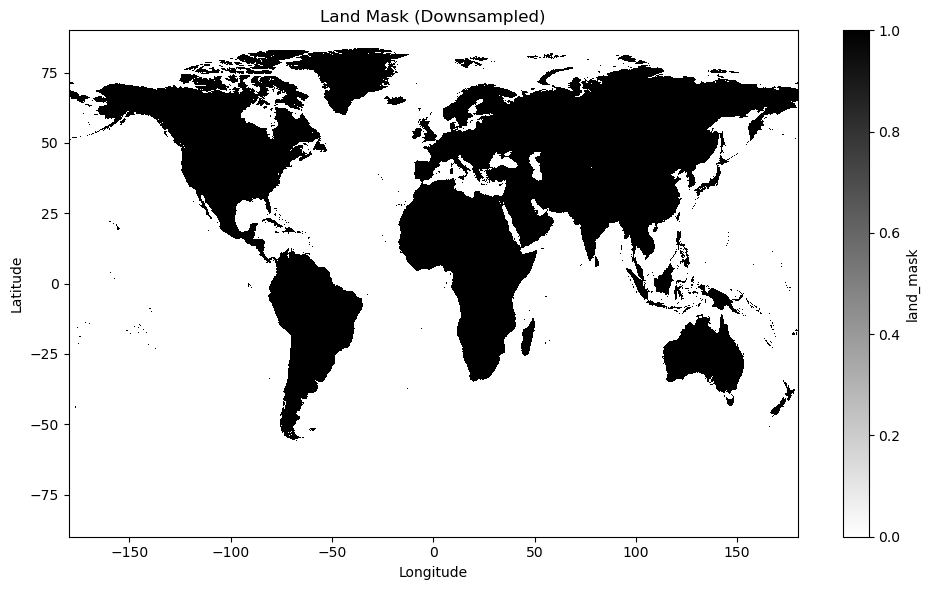

Dataset shape: (21600, 43200)
Data type: uint8


In [8]:
newmaster_path = OUT

newmaster = xr.open_dataset(newmaster_path)

import matplotlib.pyplot as plt

# The dataset is too large to plot directly, so we'll downsample it
# Downsample the data to avoid memory error
n = 10  # Adjust this value based on your memory constraints
downsampled = newmaster.land_mask.isel(lat=slice(None, None, n), lon=slice(None, None, n))

# Create a simple figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the downsampled data with simple colors
downsampled.plot(ax=ax, cmap='binary', add_colorbar=True)

# Add basic title and labels
plt.title('Land Mask (Downsampled)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

# Display basic information about the dataset
print(f"Dataset shape: {newmaster.land_mask.shape}")
print(f"Data type: {newmaster.land_mask.dtype}")


# 气候数据

## RSDS数据

In [ ]:
# batch_align_rsds.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm
import os
import re
import warnings
import psutil
warnings.filterwarnings('ignore')

def print_memory_usage():
    """打印当前内存使用情况"""
    process = psutil.Process()
    print(f"Memory usage: {process.memory_info().rss / 1024 / 1024:.2f} MB")

def process_chunk(da, lon, lat_chunk, mask_chunk):
    """处理单个数据块"""
    try:
        # 对当前块进行插值
        da_chunk = da.interp(lon=lon, lat=lat_chunk, method="linear")
        # 应用掩膜
        da_chunk_masked = da_chunk.where(mask_chunk)
        return da_chunk_masked
    except Exception as e:
        print(f"Error processing chunk: {str(e)}")
        return None

def process_file(fp, master_data, chunk_size=20):
    """处理单个文件"""
    lat, lon, mask, chunk_lat, chunk_lon = master_data
    out_nc = OUT_DIR / f"{fp.stem}.nc"
    
    if out_nc.exists():
        return f"Skipping existing file: {out_nc}"

    try:
        print(f"\nProcessing {fp.name}")
        print_memory_usage()

        # 使用更小的chunk size读取数据
        da = (
            rxr.open_rasterio(fp, masked=True,
                            chunks={"x": chunk_lon // 4, "y": chunk_lat // 4})
            .squeeze("band", drop=True)
            .rio.set_spatial_dims("x", "y", inplace=False)
            .rename({"x": "lon", "y": "lat"})
        )

        # 将纬度分成多个块进行处理
        lat_chunks = np.array_split(lat.values, chunk_size)
        da_parts = []
        
        for i, lat_chunk in enumerate(tqdm(lat_chunks, desc="Processing chunks")):
            # 获取对应的掩膜块
            mask_chunk = mask.sel(lat=lat_chunk)
            
            # 处理当前块
            da_chunk_masked = process_chunk(da, lon, lat_chunk, mask_chunk)
            if da_chunk_masked is not None:
                da_parts.append(da_chunk_masked)
            
            # 清理当前块的临时变量
            da_chunk_masked = None
            mask_chunk = None
            gc.collect()
            
            # 每处理4个块打印一次内存使用情况
            if (i + 1) % 4 == 0:
                print_memory_usage()

        # 合并所有处理后的块
        da_masked = xr.concat(da_parts, dim="lat")
        
        # 清理临时变量
        da_parts = None
        gc.collect()

        # 创建数据集并设置chunk
        var = da_masked.name or "rsds"
        ds = da_masked.to_dataset(name=var) \
                    .chunk({"lat": chunk_lat // 4, "lon": chunk_lon // 4})

        # 使用保守的压缩设置
        encoding = {
            var: {
                "zlib": True,
                "complevel": 5,  # 使用最低压缩级别
                "chunksizes": (chunk_lat // 4, chunk_lon // 4)
            }
        }
        
        # 写入文件
        ds.to_netcdf(out_nc, encoding=encoding, engine='netcdf4')
        
        result = f"Successfully processed: {fp.name}"

    except Exception as e:
        result = f"Error processing {fp}: {str(e)}"
        if out_nc.exists():
            try:
                os.remove(out_nc)
            except:
                pass
    finally:
        # 清理所有变量
        for var in ['ds', 'da', 'da_masked']:
            if var in locals():
                locals()[var] = None
        gc.collect()
        print_memory_usage()
    
    return result

def main():
    # ───────── 配置 ─────────
    global OUT_DIR
    MASTER   = Path(r"D:\xarray\aligned2\master_final.nc")
    SRC_DIR  = Path(r"D:\xarray\pre-process\Climate_rsds")
    OUT_DIR  = Path(r"D:\xarray\aligned2\rsds")
    OUT_DIR.mkdir(exist_ok=True, parents=True)

    print("Initial memory usage:")
    print_memory_usage()

    # 加载模板数据
    tmpl = xr.open_dataset(MASTER, chunks={})
    lat = tmpl["lat"]
    lon = tmpl["lon"]
    mask = tmpl["land_mask"]

    # 使用更小的chunk size
    chunk_lat = len(lat) // 100  # 进一步减小chunk大小
    chunk_lon = len(lon) // 200

    master_data = (lat, lon, mask, chunk_lat, chunk_lon)

    # 筛选目标文件
    all_files = list(SRC_DIR.glob("*.tif"))
    target_files = [fp for fp in all_files if re.search(r'(2015|2019)', fp.stem)]

    # 处理文件
    for fp in tqdm(target_files, desc="Processing files"):
        try:
            result = process_file(fp, master_data)
            print(result)
        except Exception as e:
            print(f"Error processing {fp}: {str(e)}")
            continue

    # 清理
    tmpl.close()
    gc.collect()
    print("\nFinal memory usage:")
    print_memory_usage()

    print("✅ All done! Aligned files are in:", OUT_DIR)

if __name__ == "__main__":
    main()

Initial memory usage:
Memory usage: 3846.43 MB


Processing files:   0%|          | 0/24 [00:00<?, ?it/s]

Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_01_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_02_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_03_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_04_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_05_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_06_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_07_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_08_V.2.1.nc

Processing CHELSA_rsds_2015_09_V.2.1.tif
Memory usage: 3846.73 MB


Memory usage: 4655.68 MB


Memory usage: 5370.54 MB


Memory usage: 6086.20 MB


Memory usage: 6801.21 MB


Processing chunks: 100%|██████████| 20/20 [00:37<00:00,  1.86s/it]

Memory usage: 7515.93 MB


Memory usage: 5728.23 MB


Processing files:  38%|███▊      | 9/24 [10:23<17:18, 69.24s/it]

Successfully processed: CHELSA_rsds_2015_09_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_10_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\rsds\CHELSA_rsds_2015_11_V.2.1.nc

Processing CHELSA_rsds_2015_12_V.2.1.tif
Memory usage: 4721.51 MB


Memory usage: 4828.98 MB


Memory usage: 5518.01 MB


Memory usage: 6231.32 MB


Memory usage: 6944.39 MB


Processing chunks: 100%|██████████| 20/20 [00:41<00:00,  2.08s/it]

Memory usage: 7658.75 MB


Memory usage: 4005.65 MB


Processing files:  50%|█████     | 12/24 [21:48<24:07, 120.64s/it]

Successfully processed: CHELSA_rsds_2015_12_V.2.1.tif

Processing CHELSA_rsds_2019_01_V.2.1.tif
Memory usage: 3017.48 MB


Memory usage: 1854.68 MB


Memory usage: 2147.15 MB


Memory usage: 2858.48 MB


Memory usage: 3571.75 MB


Processing chunks: 100%|██████████| 20/20 [00:44<00:00,  2.22s/it]

Memory usage: 4285.53 MB


Memory usage: 2924.27 MB


Processing files:  54%|█████▍    | 13/24 [31:15<33:00, 180.01s/it]

Successfully processed: CHELSA_rsds_2019_01_V.2.1.tif

Processing CHELSA_rsds_2019_02_V.2.1.tif
Memory usage: 2024.42 MB


Memory usage: 2122.60 MB


Memory usage: 2208.73 MB


Memory usage: 2851.67 MB


Memory usage: 3563.51 MB


Processing chunks: 100%|██████████| 20/20 [00:43<00:00,  2.16s/it]

Memory usage: 4155.71 MB


Memory usage: 2821.57 MB


Processing files:  58%|█████▊    | 14/24 [42:33<43:15, 259.56s/it]

Successfully processed: CHELSA_rsds_2019_02_V.2.1.tif

Processing CHELSA_rsds_2019_03_V.2.1.tif
Memory usage: 1967.83 MB


Memory usage: 2075.69 MB


Memory usage: 2161.14 MB


Memory usage: 2690.14 MB


Memory usage: 3401.39 MB


Processing chunks: 100%|██████████| 20/20 [00:43<00:00,  2.19s/it]

Memory usage: 4113.06 MB


Memory usage: 2859.68 MB


Processing files:  62%|██████▎   | 15/24 [52:08<47:44, 318.33s/it]

Successfully processed: CHELSA_rsds_2019_03_V.2.1.tif

Processing CHELSA_rsds_2019_04_V.2.1.tif
Memory usage: 2011.64 MB


Memory usage: 2120.66 MB


Memory usage: 2206.82 MB


Memory usage: 2648.39 MB


Memory usage: 3359.62 MB


Processing chunks: 100%|██████████| 20/20 [00:48<00:00,  2.45s/it]

Memory usage: 4071.29 MB


Memory usage: 2917.36 MB


Processing files:  67%|██████▋   | 16/24 [1:01:42<49:35, 371.91s/it]

Successfully processed: CHELSA_rsds_2019_04_V.2.1.tif

Processing CHELSA_rsds_2019_05_V.2.1.tif
Memory usage: 2055.85 MB


Memory usage: 2162.74 MB


Memory usage: 2248.30 MB


Memory usage: 2651.60 MB


Memory usage: 3361.98 MB


Processing chunks: 100%|██████████| 20/20 [00:41<00:00,  2.08s/it]

Memory usage: 4073.63 MB


Memory usage: 2950.47 MB
Successfully processed: CHELSA_rsds_2019_05_V.2.1.tif


Processing files:  71%|███████   | 17/24 [1:10:47<48:02, 411.85s/it]


Processing CHELSA_rsds_2019_06_V.2.1.tif
Memory usage: 2087.26 MB


Memory usage: 2193.37 MB


Memory usage: 2279.52 MB


Memory usage: 2649.75 MB


Memory usage: 3361.29 MB


Processing chunks: 100%|██████████| 20/20 [00:40<00:00,  2.03s/it]

Memory usage: 4072.74 MB


Memory usage: 2968.16 MB


Processing files:  75%|███████▌  | 18/24 [1:20:00<44:40, 446.81s/it]

Successfully processed: CHELSA_rsds_2019_06_V.2.1.tif

Processing CHELSA_rsds_2019_07_V.2.1.tif
Memory usage: 2089.45 MB


Memory usage: 2196.26 MB


Memory usage: 2282.67 MB


Memory usage: 2648.79 MB


Memory usage: 3359.63 MB


Processing chunks: 100%|██████████| 20/20 [00:42<00:00,  2.13s/it]

Memory usage: 4070.48 MB


Memory usage: 2963.88 MB


Processing files:  79%|███████▉  | 19/24 [1:28:33<38:40, 464.13s/it]

Successfully processed: CHELSA_rsds_2019_07_V.2.1.tif

Processing CHELSA_rsds_2019_08_V.2.1.tif
Memory usage: 2097.38 MB


Memory usage: 2200.12 MB


Memory usage: 2286.60 MB


Memory usage: 2652.37 MB


Memory usage: 3363.35 MB


Processing chunks: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]

Memory usage: 4074.34 MB


Memory usage: 2959.27 MB


Processing files:  83%|████████▎ | 20/24 [1:38:39<33:30, 502.56s/it]

Successfully processed: CHELSA_rsds_2019_08_V.2.1.tif

Processing CHELSA_rsds_2019_09_V.2.1.tif
Memory usage: 2056.93 MB


Memory usage: 2161.96 MB


Memory usage: 2248.52 MB


Memory usage: 2646.41 MB


Memory usage: 3357.70 MB


Processing chunks: 100%|██████████| 20/20 [00:52<00:00,  2.60s/it]

Memory usage: 4069.29 MB


Memory usage: 2793.78 MB


Processing files:  88%|████████▊ | 21/24 [1:50:09<27:45, 555.25s/it]

Successfully processed: CHELSA_rsds_2019_09_V.2.1.tif

Processing CHELSA_rsds_2019_10_V.2.1.tif
Memory usage: 1957.08 MB


Memory usage: 2075.30 MB


Memory usage: 2167.53 MB


Memory usage: 2583.60 MB


Memory usage: 3294.64 MB


Processing chunks: 100%|██████████| 20/20 [00:56<00:00,  2.84s/it]

Memory usage: 4006.85 MB


Memory usage: 2730.77 MB


Processing files:  92%|█████████▏| 22/24 [2:05:46<22:08, 664.20s/it]

Successfully processed: CHELSA_rsds_2019_10_V.2.1.tif

Processing CHELSA_rsds_2019_11_V.2.1.tif
Memory usage: 1900.33 MB


Memory usage: 2045.29 MB


Memory usage: 2152.39 MB


Memory usage: 2561.64 MB


Memory usage: 3273.25 MB


Processing chunks: 100%|██████████| 20/20 [00:43<00:00,  2.16s/it]

Memory usage: 3985.29 MB


Memory usage: 2873.00 MB


Processing files:  96%|█████████▌| 23/24 [2:15:54<10:47, 647.72s/it]

Successfully processed: CHELSA_rsds_2019_11_V.2.1.tif

Processing CHELSA_rsds_2019_12_V.2.1.tif
Memory usage: 1989.89 MB


Memory usage: 2093.02 MB


Memory usage: 2180.03 MB


Memory usage: 2587.76 MB


Memory usage: 3299.02 MB


Processing chunks: 100%|██████████| 20/20 [00:37<00:00,  1.88s/it]

Memory usage: 4010.47 MB


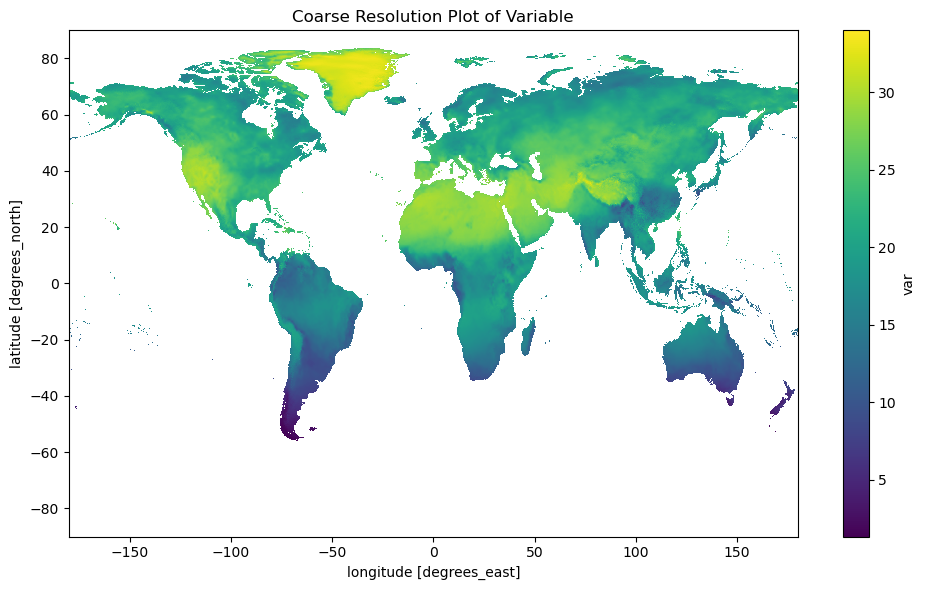

<xarray.Dataset> Size: 4GB
Dimensions:      (lon: 43200, lat: 21600)
Coordinates:
    spatial_ref  int32 4B ...
  * lon          (lon) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat          (lat) float64 173kB 90.0 89.99 89.98 ... -89.98 -89.99 -90.0
    band         int32 4B ...
    time         datetime64[ns] 8B ...
Data variables:
    var          (lat, lon) float32 4GB nan nan nan nan nan ... nan nan nan nan

In [ ]:
import xarray as xr 

ds_path=r'D:\xarray\aligned2\rsds\CHELSA_rsds_2015_06_V.2.1.nc'
ds=xr.open_dataset(ds_path)
import matplotlib.pyplot as plt

# Plot the variable with coarse resolution for better performance
plt.figure(figsize=(10, 6))
ds['var'].coarsen(lat=20, lon=20).mean().plot()
plt.title('Coarse Resolution Plot of Variable')
plt.tight_layout()
plt.show()





In [6]:
MASTER = r"D:\xarray\aligned2\master_final.nc"
ds = xr.open_dataset(ds_path)
FINAL = r"D:\xarray\final_mask_1km_new.nc"

# 打印三者的经度与纬度分辨率，并观察小数位数后几位
master_ds = xr.open_dataset(MASTER)
final_ds = xr.open_dataset(FINAL)

print("MASTER resolution:")
print(f"Longitude resolution: {master_ds.lon[1] - master_ds.lon[0]:.15f}")
print(f"Latitude resolution: {master_ds.lat[0] - master_ds.lat[1]:.15f}")

print("\nds resolution:")
print(f"Longitude resolution: {ds.lon[1] - ds.lon[0]:.15f}")
print(f"Latitude resolution: {ds.lat[0] - ds.lat[1]:.15f}")

print("\nFINAL resolution:")
print(f"Longitude resolution: {final_ds.lon[1] - final_ds.lon[0]:.15f}")
print(f"Latitude resolution: {final_ds.lat[0] - final_ds.lat[1]:.15f}")

# 关闭数据集以释放内存
master_ds.close()
final_ds.close()


MASTER resolution:
Longitude resolution: 0.008333333333326
Latitude resolution: 0.008333333333354

ds resolution:
Longitude resolution: 0.008333333333326
Latitude resolution: 0.008333333333354

FINAL resolution:
Longitude resolution: 0.008333333333326
Latitude resolution: 0.008333333333354


## TAS气温并取平均

In [9]:
# batch_align_lowmem.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm
import os
import re

# ───────── 配置 ─────────
MASTER   = Path(r"D:\xarray\aligned2\master_final.nc")
SRC_DIR  = Path(r"D:\xarray\pre-process\Climate_tas")
OUT_DIR  = Path(r"D:\xarray\aligned2\tas")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ───────── 1. 读取模板 & 掩膜 ─────────
tmpl = xr.open_dataset(MASTER, chunks={})
lat  = tmpl["lat"]                # size 21600
lon  = tmpl["lon"]                # size 43200
mask = tmpl["land_mask"]          # bool mask

# 选一个能整除的块大小，保证 chunksizes 合法
chunk_lat = len(lat) // 40        # 21600 / 40 = 540
chunk_lon = len(lon) // 80        # 43200 / 80 = 540

# ───────── 2. 批量处理所有 .tif ─────────
# 筛选出2015年、2018年和2019年的文件
all_files = list(SRC_DIR.glob("*.tif"))
target_files = []
for fp in all_files:
    # 使用正则表达式检查文件名中是否包含2015、2018或2019年
    if re.search(r'(2015|2018|2019)', fp.stem):
        target_files.append(fp)

for fp in tqdm(target_files, desc="Aligning TIFs"):
    out_nc = OUT_DIR / f"{fp.stem}.nc"
    
    # 如果文件已存在，则跳过处理
    if out_nc.exists():
        print(f"Skipping existing file: {out_nc}")
        continue

    try:
        # 2.1 读入时就分块
        da = (
            rxr.open_rasterio(fp, masked=True,
                              chunks={"x": chunk_lon, "y": chunk_lat})
              .squeeze("band", drop=True)
              .rio.set_spatial_dims("x", "y", inplace=False)
              .rename({"x": "lon", "y": "lat"})
        )

        # 2.2 按模板经纬度插值对齐（使用线性插值但降低内存使用）
        # 为了避免内存错误，我们将插值操作分成多个小块处理
        lat_chunks = np.array_split(lat.values, 10)  # 将纬度分成10个块
        da_parts = []
        
        for lat_chunk in lat_chunks:
            # 对每个纬度块进行插值
            da_chunk = da.interp(lon=lon, lat=lat_chunk, method="linear")
            # 应用掩膜
            mask_chunk = mask.sel(lat=lat_chunk)
            da_chunk_masked = da_chunk.where(mask_chunk)
            da_parts.append(da_chunk_masked)
            
            # 立即清理内存
            da_chunk = None
            mask_chunk = None
            gc.collect()
        
        # 沿纬度方向合并所有块
        da_masked = xr.concat(da_parts, dim="lat")
        
        # 清理临时变量
        da_parts = None
        gc.collect()

        # 2.4 构造 Dataset 并分块
        var = da_masked.name or "var"
        ds = da_masked.to_dataset(name=var) \
                      .chunk({"lat": chunk_lat, "lon": chunk_lon})

        # 2.5 写出 NetCDF（合法 chunksizes + 压缩）
        encoding = {
            var: {
                "zlib": True,
                "complevel": 5,
                "chunksizes": (chunk_lat, chunk_lon)
            }
        }
        # 使用compute=True确保立即计算并写入文件
        ds.to_netcdf(out_nc, encoding=encoding, compute=True)

    except Exception as e:
        print(f"Error processing {fp}: {str(e)}")
        # 如果处理失败，删除可能部分写入的文件
        if out_nc.exists():
            try:
                os.remove(out_nc)
                print(f"Removed incomplete file: {out_nc}")
            except:
                print(f"Failed to remove incomplete file: {out_nc}")
    finally:
        # 2.6 关闭 & 回收
        try:
            if 'ds' in locals():
                ds.close()
            if 'da' in locals():
                da = None
            if 'da_masked' in locals():
                da_masked = None
            gc.collect()
        except:
            pass

print("✅ All done! Aligned files are in:", OUT_DIR)


Aligning TIFs: 100%|██████████| 36/36 [1:17:17<00:00, 128.82s/it]

✅ All done! Aligned files are in: D:\xarray\aligned2\tas


## WIND风速

In [ ]:
# batch_align_rsds.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm
import os
import re
import warnings
import psutil
warnings.filterwarnings('ignore')

def print_memory_usage():
    """打印当前内存使用情况"""
    process = psutil.Process()
    print(f"Memory usage: {process.memory_info().rss / 1024 / 1024:.2f} MB")

def process_chunk(da, lon, lat_chunk, mask_chunk):
    """处理单个数据块"""
    try:
        # 对当前块进行插值
        da_chunk = da.interp(lon=lon, lat=lat_chunk, method="linear")
        # 应用掩膜
        da_chunk_masked = da_chunk.where(mask_chunk)
        return da_chunk_masked
    except Exception as e:
        print(f"Error processing chunk: {str(e)}")
        return None

def process_file(fp, master_data, chunk_size=20):
    """处理单个文件"""
    lat, lon, mask, chunk_lat, chunk_lon = master_data
    out_nc = OUT_DIR / f"{fp.stem}.nc"
    
    if out_nc.exists():
        return f"Skipping existing file: {out_nc}"

    try:
        print(f"\nProcessing {fp.name}")
        print_memory_usage()

        # 使用更小的chunk size读取数据
        da = (
            rxr.open_rasterio(fp, masked=True,
                            chunks={"x": chunk_lon // 4, "y": chunk_lat // 4})
            .squeeze("band", drop=True)
            .rio.set_spatial_dims("x", "y", inplace=False)
            .rename({"x": "lon", "y": "lat"})
        )

        # 将纬度分成多个块进行处理
        lat_chunks = np.array_split(lat.values, chunk_size)
        da_parts = []
        
        for i, lat_chunk in enumerate(tqdm(lat_chunks, desc="Processing chunks")):
            # 获取对应的掩膜块
            mask_chunk = mask.sel(lat=lat_chunk)
            
            # 处理当前块
            da_chunk_masked = process_chunk(da, lon, lat_chunk, mask_chunk)
            if da_chunk_masked is not None:
                da_parts.append(da_chunk_masked)
            
            # 清理当前块的临时变量
            da_chunk_masked = None
            mask_chunk = None
            gc.collect()
            
            # 每处理4个块打印一次内存使用情况
            if (i + 1) % 4 == 0:
                print_memory_usage()

        # 合并所有处理后的块
        da_masked = xr.concat(da_parts, dim="lat")
        
        # 清理临时变量
        da_parts = None
        gc.collect()

        # 创建数据集并设置chunk
        var = da_masked.name or "rsds"
        ds = da_masked.to_dataset(name=var) \
                    .chunk({"lat": chunk_lat // 4, "lon": chunk_lon // 4})

        # 使用保守的压缩设置
        encoding = {
            var: {
                "zlib": True,
                "complevel": 5,  # 使用最低压缩级别
                "chunksizes": (chunk_lat // 4, chunk_lon // 4)
            }
        }
        
        # 写入文件
        ds.to_netcdf(out_nc, encoding=encoding, engine='netcdf4')
        
        result = f"Successfully processed: {fp.name}"

    except Exception as e:
        result = f"Error processing {fp}: {str(e)}"
        if out_nc.exists():
            try:
                os.remove(out_nc)
            except:
                pass
    finally:
        # 清理所有变量
        for var in ['ds', 'da', 'da_masked']:
            if var in locals():
                locals()[var] = None
        gc.collect()
        print_memory_usage()
    
    return result

def main():
    # ───────── 配置 ─────────
    global OUT_DIR
    MASTER   = Path(r"D:\xarray\aligned2\master_final.nc")
    SRC_DIR  = Path(r"D:\xarray\pre-process\Climate_wind")
    OUT_DIR  = Path(r"D:\xarray\aligned2\wind")
    OUT_DIR.mkdir(exist_ok=True, parents=True)

    print("Initial memory usage:")
    print_memory_usage()

    # 加载模板数据
    tmpl = xr.open_dataset(MASTER, chunks={})
    lat = tmpl["lat"]
    lon = tmpl["lon"]
    mask = tmpl["land_mask"]

    # 使用更小的chunk size
    chunk_lat = len(lat) // 100  # 进一步减小chunk大小
    chunk_lon = len(lon) // 200

    master_data = (lat, lon, mask, chunk_lat, chunk_lon)

    # 筛选目标文件
    all_files = list(SRC_DIR.glob("*.tif"))
    target_files = [fp for fp in all_files if re.search(r'(2015|2019)', fp.stem)]

    # 处理文件
    for fp in tqdm(target_files, desc="Processing files"):
        try:
            result = process_file(fp, master_data)
            print(result)
        except Exception as e:
            print(f"Error processing {fp}: {str(e)}")
            continue

    # 清理
    tmpl.close()
    gc.collect()
    print("\nFinal memory usage:")
    print_memory_usage()

    print("✅ All done! Aligned files are in:", OUT_DIR)

if __name__ == "__main__":
    main()